In [5]:
from blayers.layers import InterceptLayer, AdaptiveLayer
from blayers.links import gaussian_link_exp
from blayers.infer import Batched_Trace_ELBO, svi_run_batched
from jax import random
import optax
from numpyro.infer import Predictive
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer.svi import SVI
# Use a non-interactive backend so the script works in headless environments.
import matplotlib.pyplot as plt
import jax.numpy as jnp

In [6]:
# -----------------------------
# 1) Data generation
# -----------------------------
def make_synthetic(key, n=1024, d=6):
    key, kx, kbeta, knoise = random.split(key, 4)
    X = random.normal(kx, (n, d))
    true_intercept = 0.75
    true_beta = random.normal(kbeta, (d, 1)) * 0.7
    noise = random.normal(knoise, (n, 1)) * 0.5
    y = X @ true_beta + true_intercept + noise
    return (key, X, y)

# -----------------------------
# 2) Model
# -----------------------------
def model(x, y=None):
    """
    Simple additive mean function with an adaptive prior on linear weights,
    plus a learned intercept. Likelihood is Normal with sigma ~ Exp(1).
    """
    mu_linear = AdaptiveLayer(units=1)(name="linear", x=x)      # (n, 1)
    mu_intercept = InterceptLayer(units=1)(name="intercept")    # (1, 1) -> broadcasts
    y_hat = mu_linear + mu_intercept
    return gaussian_link_exp(y_hat, y=y)  # samples site "obs"


In [7]:
# -----------------------------
# 3) Train with SVI
# -----------------------------
def train_svi(key, X, y, batch_size=128, num_epochs=5, lr=1e-2):
    """
    Uses AutoNormal guide + Batched_Trace_ELBO (no plates).
    """
    guide = AutoDiagonalNormal(model)

    num_obs = X.shape[0]
    elbo = Batched_Trace_ELBO(num_obs=num_obs, batch_size=batch_size)
    optimizer = optax.adam(lr)
    svi = SVI(model, guide, optimizer, loss=elbo)

    key, ktrain = random.split(key)
    result = svi_run_batched(
        svi,
        rng_key=ktrain,
        batch_size=batch_size,
        num_epochs=num_epochs,
        x=X,
        y=y,
    )
    return key, guide, result


# -----------------------------
# 4) Posterior predictive
# -----------------------------
def posterior_predictive(key, guide, params, X, num_ppc=500):
    predictive = Predictive(model, guide=guide, params=params, num_samples=num_ppc)
    key, kppc = random.split(key)
    ppc = predictive(kppc, x=X)
    return key, ppc


def plot_losses(losses, path="svi_loss.png"):
    plt.figure()
    plt.plot(losses)
    plt.xlabel("step")
    plt.ylabel("ELBO (negative)")
    plt.title("SVI loss")
    plt.tight_layout()
    plt.show()


def plot_ppc(y_true, y_pred_mean, path="ppc_fit.png"):
    y_true = jnp.asarray(y_true).reshape(-1)
    y_pred_mean = jnp.asarray(y_pred_mean).reshape(-1)

    mn = float(jnp.minimum(y_true.min(), y_pred_mean.min()))
    mx = float(jnp.maximum(y_true.max(), y_pred_mean.max()))

    plt.figure()
    plt.scatter(y_true, y_pred_mean, s=10, alpha=0.6)
    plt.plot([mn, mx], [mn, mx])
    plt.xlabel("True y")
    plt.ylabel("Posterior mean prediction")
    plt.title("Posterior predictive fit")
    plt.tight_layout()
    plt.show()

In [8]:

# Reproducibility
key = random.PRNGKey(0)

# Data
key, X, y = make_synthetic(key, n=1024, d=6)
print(f"Data: X.shape={X.shape}, y.shape={y.shape}")

# Train
key, guide, result = train_svi(key, X, y, batch_size=128, num_epochs=5, lr=1e-2)

# Losses
losses = jnp.asarray(result.losses)
final_loss = float(losses[-1])
print(f"Final SVI loss: {final_loss:,.3f}")

# Posterior predictive
key, ppc = posterior_predictive(key, guide, result.params, X, num_ppc=500)
y_pred_mean = ppc["obs"].mean(axis=0)  # (n, 1)
rmse = float(jnp.sqrt(jnp.mean((y_pred_mean - y) ** 2)))
print(f"Posterior predictive RMSE: {rmse:,.4f}")

Data: X.shape=(1024, 6), y.shape=(1024, 1)


100%|██████████| 40/40 [00:00<00:00, 167.89it/s]

Final SVI loss: 22,809.234
Posterior predictive RMSE: 2.3242


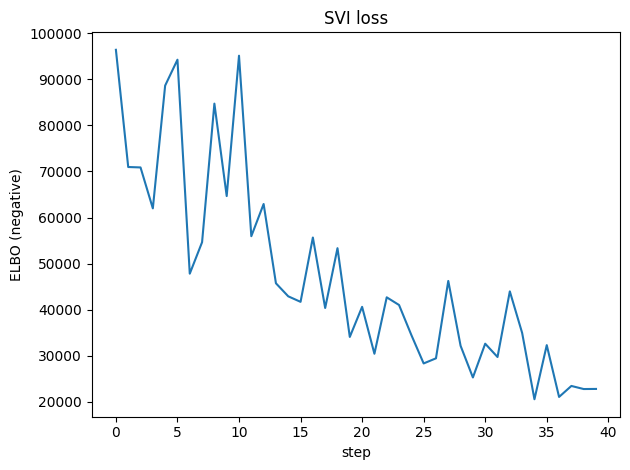

In [9]:
loss_png = plot_losses(losses, path="svi_loss.png")

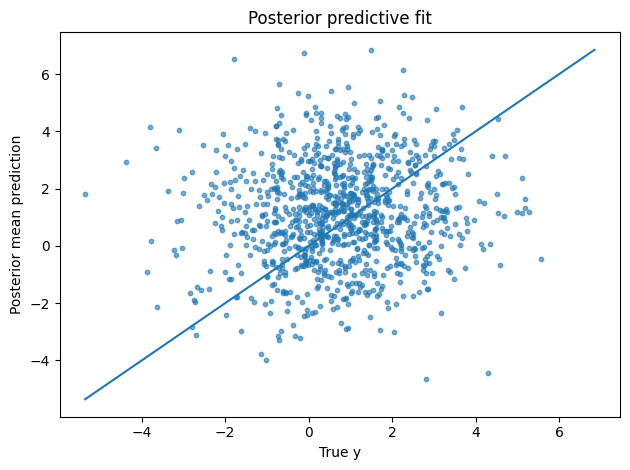

In [10]:
ppc_png = plot_ppc(y, y_pred_mean, path="ppc_fit.png")